In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import pretreat_data

# Path to the data
train_path = "../data/ClimateTrain.csv"
test_path = "../data/ClimateTest.csv"

# Read as pandas dataframe and transform dates to datetime
train_df = pd.read_csv(train_path)
train_df['date'] = pd.to_datetime(train_df['date'])

test_df = pd.read_csv(test_path)
test_df['date'] = pd.to_datetime(test_df['date'])

# Plot description
train_df.describe()
test_df.describe()

,date,meantemp,humidity,wind_speed,meanpressure
count,114,114.000000,114.000000,114.000000,114.000000
mean,2017-02-26 12:00:00,21.713079,56.258362,8.143924,1004.035090
min,2017-01-01 00:00:00,11.000000,17.750000,1.387500,59.000000
25%,2017-01-29 06:00:00,16.437198,39.625000,5.563542,1007.437500
50%,2017-02-26 12:00:00,19.875000,57.750000,8.069444,1012.739316
75%,2017-03-26 18:00:00,27.705357,71.902778,10.068750,1016.739583
max,2017-04-24 00:00:00,34.500000,95.833333,19.314286,1022.809524
std,NaN,6.360072,19.068083,3.588049,89.474692


## Pretreat the data

In [2]:
train_df, test_df = pretreat_data(train_df, test_df)

Pre-treating data...


## Plot to double check that data looks okay

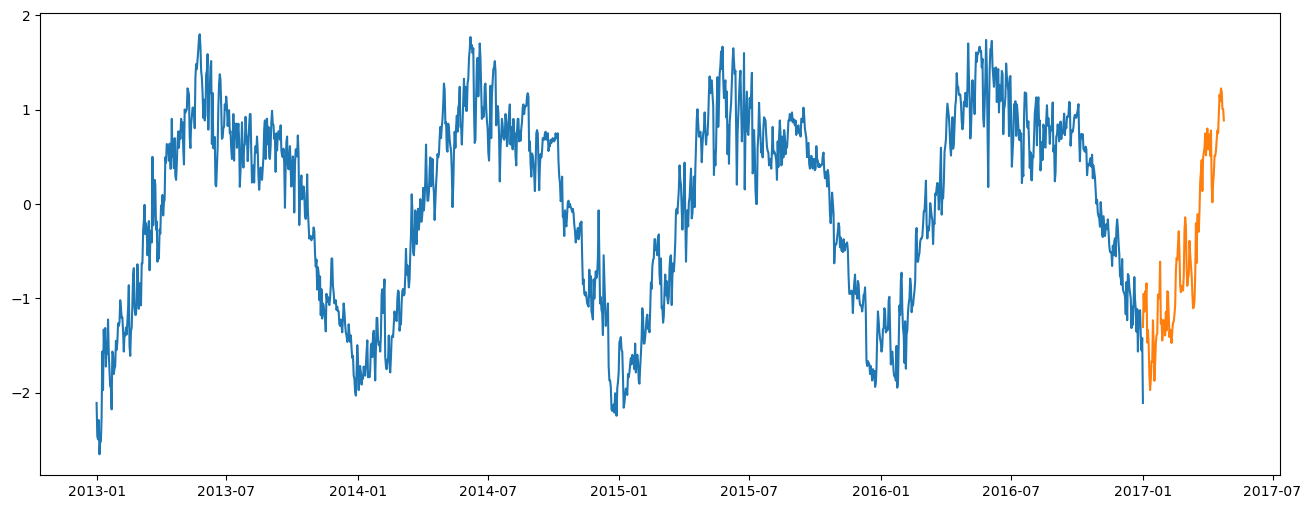

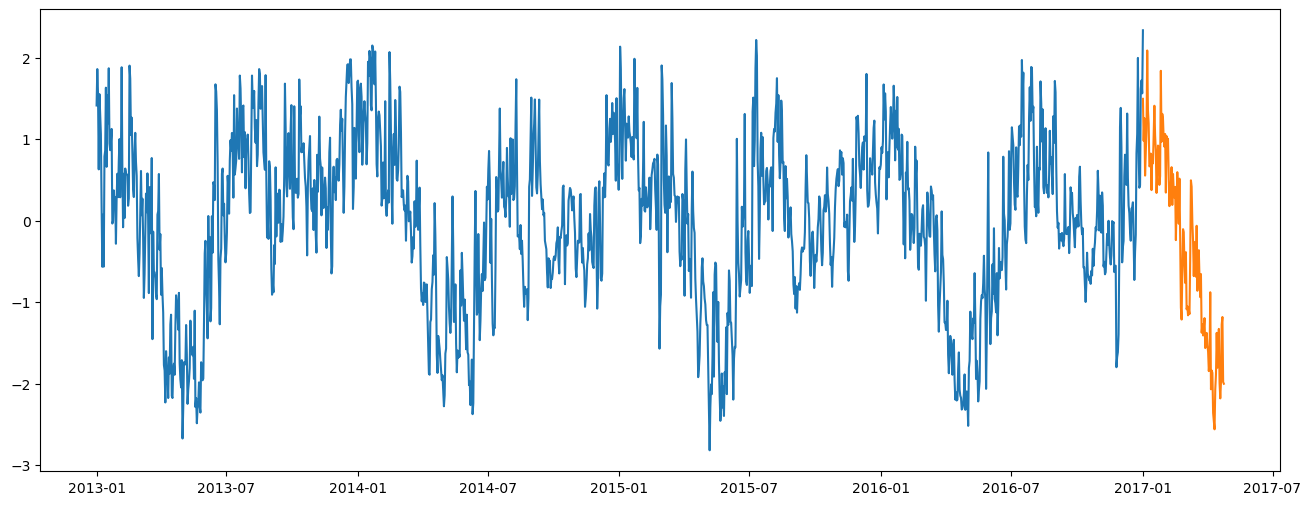

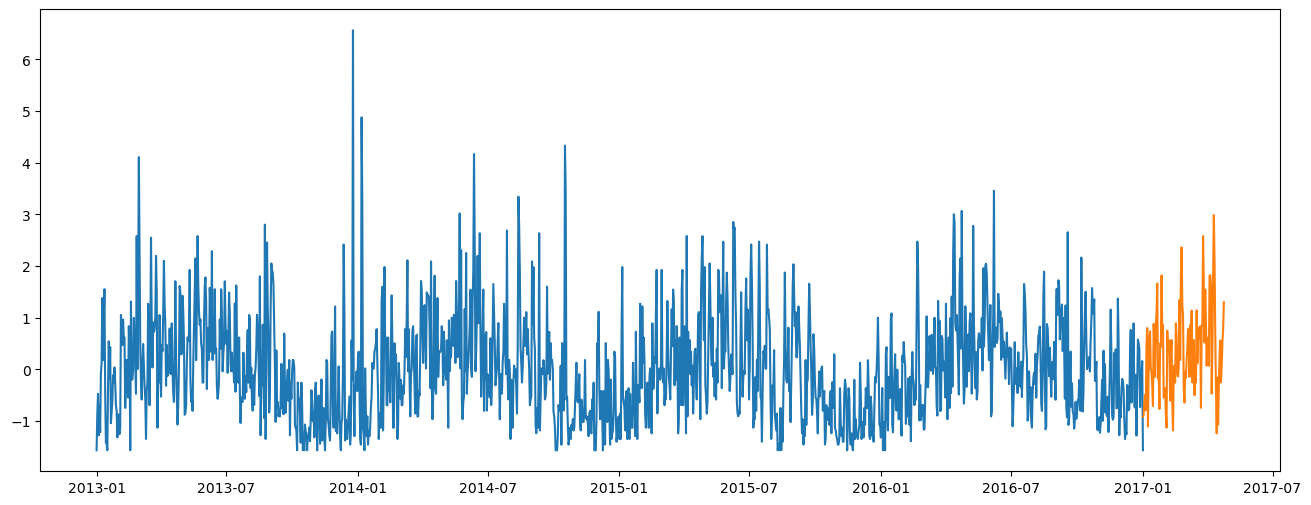

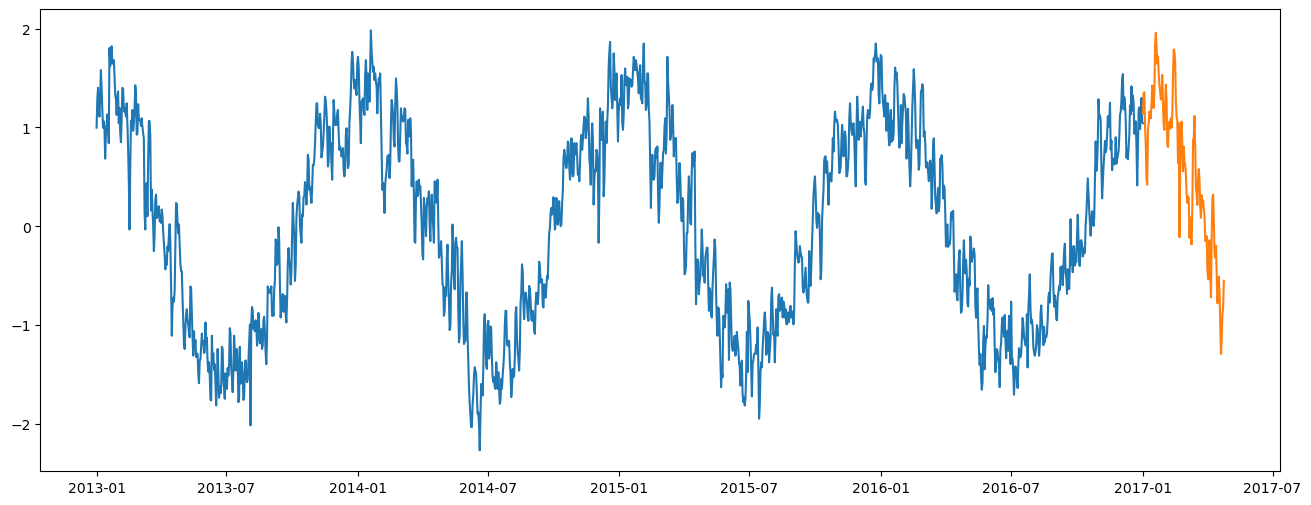

In [3]:
for col in train_df.columns[1:]:
    plt.figure(figsize=(16,6))
    plt.plot(train_df["date"], train_df[col])
    plt.plot(test_df["date"], test_df[col])
    

# 1.0 Initialize the model

In [4]:
from utils import rolling_train_valid_split
from trainer import train, validate
from dataset import TimeSeriesDataset
from models import RNN_model
from torch import nn, optim
from torch.utils.data import DataLoader
import torch


# number of points
window_size = 25
num_time_steps = 50
hidden_size = 128
n_layers = 2
output_size = 1


model = RNN_model(hidden_size=hidden_size, n_layers=n_layers, out_features=output_size, dropout_p=0.3)

# Define batch size
batch_size = 32
lr = 0.01
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)


## 1.1 Train

In [5]:
# Generate rolling train-validation splits
validation_window = 10
window_size = 50
n_epochs = 100

for i, (train_data, valid_data) in enumerate(rolling_train_valid_split(train_df, months=6, window_size=window_size)):
    if valid_data is not None:
        train_dataset = TimeSeriesDataset(df=train_data, window_size=window_size, horizon=1)
        valid_dataset = TimeSeriesDataset(df=valid_data, window_size=window_size, horizon=1)
        
        # Initialize the dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

        
        for epoch in range(n_epochs):
            avg_train_loss = train(model, train_loader, criterion, optimizer, device)
            avg_val_loss = validate(model, valid_loader, criterion, device)
            print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/100, Train Loss: 1.1603, Val Loss: 0.7624
Epoch 2/100, Train Loss: 0.6670, Val Loss: 0.3708
Epoch 3/100, Train Loss: 0.4860, Val Loss: 0.4463
Epoch 4/100, Train Loss: 0.6190, Val Loss: 0.3995
Epoch 5/100, Train Loss: 0.5322, Val Loss: 0.3541
Epoch 6/100, Train Loss: 0.4832, Val Loss: 0.3873
Epoch 7/100, Train Loss: 0.5110, Val Loss: 0.3595
Epoch 8/100, Train Loss: 0.5238, Val Loss: 0.6237
Epoch 9/100, Train Loss: 0.6157, Val Loss: 0.4195
Epoch 10/100, Train Loss: 0.5081, Val Loss: 0.3969
Epoch 11/100, Train Loss: 0.5080, Val Loss: 0.4422
Epoch 12/100, Train Loss: 0.5385, Val Loss: 0.3870
Epoch 13/100, Train Loss: 0.5064, Val Loss: 0.5593
Epoch 14/100, Train Loss: 0.5177, Val Loss: 0.3690
Epoch 15/100, Train Loss: 0.4725, Val Loss: 0.4136
Epoch 16/100, Train Loss: 0.4425, Val Loss: 0.3386
Epoch 17/100, Train Loss: 0.4686, Val Loss: 0.3051
Epoch 18/100, Train Loss: 0.4473, Val Loss: 0.3627
Epoch 19/100, Train Loss: 0.4920, Val Loss: 0.3069
Epoch 20/100, Train Loss: 0.4855, Val Lo

KeyboardInterrupt: 